# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [123]:
import pandas as pd
import numpy as np
import math
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline 

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Look at the Data

In [52]:
# Checking the columns of portfolio dataset
portfolio.columns

Index(['reward', 'channels', 'difficulty', 'duration', 'offer_type', 'id'], dtype='object')

In [53]:
# Checking the columns of profile dataset
profile.columns

Index(['gender', 'age', 'id', 'became_member_on', 'income'], dtype='object')

In [54]:
# Checking the columns of transcript dataset
transcript.columns

Index(['person', 'event', 'value', 'time'], dtype='object')

In [55]:
# Checking missing values at portfolio dataset
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [56]:
# Checking missing values at profile dataset
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [57]:
# Checking missing values at transcript dataset
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [58]:
# Checking all columns of portfolio dataset
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


# Exploratory Data Analysis

In [59]:
# checking the distribution of offer types
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

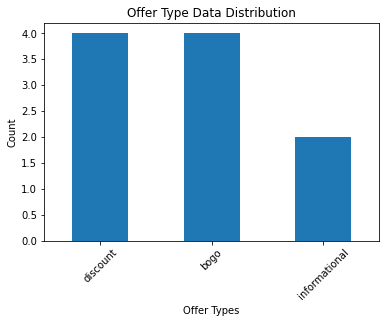

In [60]:
# checking offer types distribution through bar plot 
ax = portfolio.offer_type.value_counts()
ax.plot(kind='bar', rot=45)
plt.xlabel('Offer Types')
plt.ylabel('Count')
plt.title('Offer Type Data Distribution');

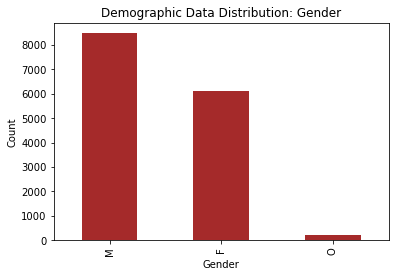

In [61]:
# checking gender data distribution 
ax = profile.gender.value_counts()
ax.plot(kind='bar',color = 'brown')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Demographic Data Distribution: Gender');

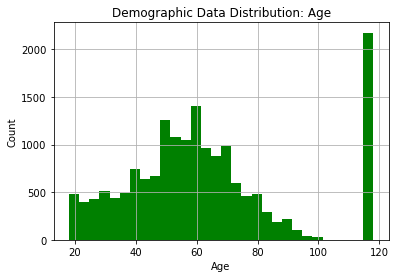

In [62]:
# checking age data distribution
ax = profile.age.hist(bins = 30, facecolor = 'green')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Demographic Data Distribution: Age');

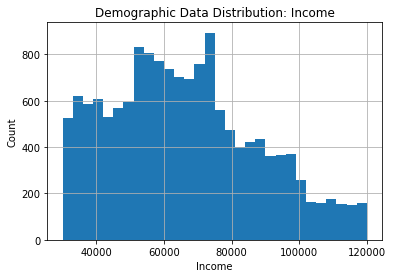

In [63]:
# checking income data distribution
ax = profile.income.hist(bins = 30)
plt.xlabel('Income')
plt.ylabel('Count')
plt.title('Demographic Data Distribution: Income');

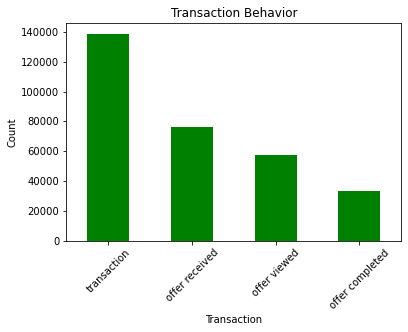

In [64]:
# checking transaction behavior
ax = transcript.event.value_counts()
ax.plot(kind='bar',rot = 45,color='green')
plt.xlabel('Transaction')
plt.ylabel('Count')
plt.title('Transaction Behavior');

# Cleaning and Merging Data

In [65]:
# Processing portfolio Dataset
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [66]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [67]:
# modifying categorical values of the offer_type column to numerical
portfolio['offer_type'] = portfolio['offer_type'].map({'bogo':1, 'informational':2, 'discount':3})
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,1,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,2,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,3,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [68]:
# rename id to offer_id to keep similarity with other datasets
portfolio.rename(columns={"id": "offer_id"},inplace =True)

In [69]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,1,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,2,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,3,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [70]:
# Channels column is categorical, therefore, its need to be changed to numerical
portfolio=portfolio.drop('channels', axis = 1).join(portfolio.channels.str.join('|').str.get_dummies())
portfolio.columns

Index(['reward', 'difficulty', 'duration', 'offer_type', 'offer_id', 'email',
       'mobile', 'social', 'web'],
      dtype='object')

In [71]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,2,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,3,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [72]:
# Processing profile Dataset
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [73]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [74]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [75]:
profile['age'].value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [76]:
profile.shape

(17000, 5)

In [77]:
#taking care of age of 118
profile[profile['age']==118][['gender','age','income']]

,gender,age,income
0,None,118,NaN
2,None,118,NaN
4,None,118,NaN
6,None,118,NaN
7,None,118,NaN
...,...,...,...
16980,None,118,NaN
16982,None,118,NaN
16989,None,118,NaN
16991,None,118,NaN


In [78]:
profile[profile['age']==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [79]:
# As it is observed that age of 118 is not possible and the income and gender info is also Nan,
# therefore, we can drop these information, these are not important.
profile.dropna(inplace = True)

In [80]:
profile.isnull().sum()

gender              0
age                 0
id                  0
became_member_on    0
income              0
dtype: int64

In [81]:
# renaming id to customer_id to keep the similarity with other dataset
profile.rename(columns={"id": "customer_id"},inplace =True)

In [82]:
# modifying gender column from categorical to numerical
profile['gender'] = profile['gender'].map({'M':1, 'F':2, 'O':3})
profile.head()

,gender,age,customer_id,became_member_on,income
1,2,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0


In [83]:
# converting became_member_on column to standard datetime 
profile['became_member_on']= pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile.head()

,gender,age,customer_id,became_member_on,income
1,2,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [84]:
# converting to member year and month
profile['member_year'] = pd.DatetimeIndex(profile['became_member_on']).year
profile['member_month'] = pd.DatetimeIndex(profile['became_member_on']).month
profile.head()

,gender,age,customer_id,became_member_on,income,member_year,member_month
1,2,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,7
3,2,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,5
5,1,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018,4
8,1,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018,2
12,1,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017,11


In [85]:
# dropping became_member_on column as it is already converted into year and month
profile.drop('became_member_on',axis = 1,inplace = True)

In [86]:
# checking profile columns
profile.columns

Index(['gender', 'age', 'customer_id', 'income', 'member_year',
       'member_month'],
      dtype='object')

In [87]:
# checking all information of profile dataset
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        14825 non-null  int64  
 1   age           14825 non-null  int64  
 2   customer_id   14825 non-null  object 
 3   income        14825 non-null  float64
 4   member_year   14825 non-null  int64  
 5   member_month  14825 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 810.7+ KB


In [88]:
#Processing transcript Dataset
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [89]:
# event column is categorical, it needs to be changed into numerical
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [90]:
# mapping event column
transcript['event'] = transcript['event'].map({'offer completed':1, 'offer received':2, 'offer viewed':3,'transaction':4})
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,2,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [91]:
# checking missing values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [92]:
# renaming person column to customer_id to keep similarity with other dataset
transcript.rename(columns={"person": "customer_id"},inplace = True)

In [93]:
# expanding value column
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [94]:
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,2,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [95]:
# it is obsevered that there are two columns related to offer_id, we will need to combine those

condition = transcript['offer id'].isnull() & transcript['offer_id'].notnull()
transcript['offer_id'] = np.where(condition, transcript['offer_id'],transcript['offer id'])

In [96]:
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,2,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,2,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,2,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,2,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,2,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [97]:
transcript['offer_id']

0         9b98b8c7a33c4b65b9aebfe6a799e6d9
1         0b1e1539f2cc45b7b9fa7c272da2e1d7
2         2906b810c7d4411798c6938adc9daaa5
3         fafdcd668e3743c1bb461111dcafc2a4
4         4d5c57ea9a6940dd891ad53e9dbe8da0
                        ...               
306529                                 NaN
306530                                 NaN
306531                                 NaN
306532                                 NaN
306533                                 NaN
Name: offer_id, Length: 306534, dtype: object

In [98]:
#fill Nan 
transcript.fillna(0, inplace = True)

In [99]:
# checking missing values
transcript.isnull().sum()

customer_id    0
event          0
value          0
time           0
offer id       0
amount         0
offer_id       0
reward         0
dtype: int64

In [100]:
# dropping extra columns
transcript.drop(['reward','offer id','value'],axis = 1,inplace = True)

In [101]:
transcript.columns

Index(['customer_id', 'event', 'time', 'amount', 'offer_id'], dtype='object')

In [102]:
# merging portfolio and transcript datasets
data = pd.merge(portfolio, transcript, on='offer_id')

In [103]:
data.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,customer_id,event,time,amount
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,2,0,0.0
1,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1e9420836d554513ab90eba98552d0a9,2,0,0.0
2,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,02c083884c7d45b39cc68e1314fec56c,2,0,0.0
3,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,676506bad68e4161b9bbaffeb039626b,2,0,0.0
4,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,fe8264108d5b4f198453bbb1fa7ca6c9,2,0,0.0


In [104]:
# merging with profile dataset
Combined_data = pd.merge(data, profile, on='customer_id')

In [105]:
# checking combined dataset
Combined_data.head()

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web,customer_id,event,time,amount,gender,age,income,member_year,member_month
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,2,0,0.0,1,64,100000.0,2017,9
1,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,3,102,0.0,1,64,100000.0,2017,9
2,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,2,504,0.0,1,64,100000.0,2017,9
3,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,3,510,0.0,1,64,100000.0,2017,9
4,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,4b0da7e80e5945209a1fdddfe813dbe0,1,510,0.0,1,64,100000.0,2017,9


In [106]:
# selecting important columns
Combined_data = Combined_data.drop(['customer_id','offer_id','member_year','member_month'],axis =1)

In [107]:
# checking the columns of the combined data
Combined_data.columns

Index(['reward', 'difficulty', 'duration', 'offer_type', 'email', 'mobile',
       'social', 'web', 'event', 'time', 'amount', 'gender', 'age', 'income'],
      dtype='object')

In [108]:
# scaling combined data
column_scaled = ['income', 'difficulty', 'duration', 'reward', 'time', 'amount','age']
Combined_data[column_scaled] = StandardScaler().fit_transform(Combined_data[column_scaled])

# Building Machine Learning Model and evaluation

In [109]:
# Selecting features and targets for the model
X = Combined_data.drop(['event'], axis = 1)
y = Combined_data["event"]

In [110]:
X.shape, y.shape

((148805, 13), (148805,))

In [111]:
# Splitting Data set into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [112]:
# Evaluating the model
def evaluation_model(classifier):
    '''
    This fuction evaluates different classifier
    Input:
    All the classifiers that have been choosen
    Output:
    Precission, recall, f1-score, accuracy 
    '''
    
    train_prediction =  (classifier.fit(X_train, y_train)).predict(X_train)
    test_prediction = (classifier.fit(X_train, y_train)).predict(X_test)
    target_names = ['class 0', 'class 1', 'class 2']
    print(classifier,":Training Set:\n",classification_report(y_train, train_prediction, target_names=target_names))
    print(classifier,":Testing Set\n",classification_report(y_test, test_prediction, target_names=target_names))
    return

In [113]:
evaluation_model(RandomForestClassifier())

RandomForestClassifier() :Training Set:
               precision    recall  f1-score   support

     class 0       0.97      0.94      0.96     19606
     class 1       0.91      0.97      0.94     39922
     class 2       0.95      0.88      0.91     29755

    accuracy                           0.94     89283
   macro avg       0.94      0.93      0.94     89283
weighted avg       0.94      0.94      0.94     89283

RandomForestClassifier() :Testing Set
               precision    recall  f1-score   support

     class 0       0.41      0.36      0.39     12838
     class 1       0.73      0.81      0.77     26579
     class 2       0.45      0.42      0.43     20105

    accuracy                           0.58     59522
   macro avg       0.53      0.53      0.53     59522
weighted avg       0.57      0.58      0.57     59522



In [114]:
evaluation_model(KNeighborsClassifier(n_neighbors = 5))

KNeighborsClassifier() :Training Set:
               precision    recall  f1-score   support

     class 0       0.59      0.58      0.59     19606
     class 1       0.64      0.87      0.74     39922
     class 2       0.68      0.35      0.46     29755

    accuracy                           0.64     89283
   macro avg       0.64      0.60      0.60     89283
weighted avg       0.64      0.64      0.61     89283

KNeighborsClassifier() :Testing Set
               precision    recall  f1-score   support

     class 0       0.35      0.34      0.34     12838
     class 1       0.52      0.72      0.61     26579
     class 2       0.32      0.16      0.22     20105

    accuracy                           0.45     59522
   macro avg       0.40      0.41      0.39     59522
weighted avg       0.42      0.45      0.42     59522



In [115]:
evaluation_model(DecisionTreeClassifier(random_state = 10))

DecisionTreeClassifier(random_state=10) :Training Set:
               precision    recall  f1-score   support

     class 0       0.92      1.00      0.96     19606
     class 1       0.91      0.98      0.94     39922
     class 2       1.00      0.84      0.91     29755

    accuracy                           0.94     89283
   macro avg       0.94      0.94      0.94     89283
weighted avg       0.94      0.94      0.93     89283

DecisionTreeClassifier(random_state=10) :Testing Set
               precision    recall  f1-score   support

     class 0       0.45      0.49      0.47     12838
     class 1       0.81      0.80      0.81     26579
     class 2       0.51      0.49      0.50     20105

    accuracy                           0.63     59522
   macro avg       0.59      0.60      0.59     59522
weighted avg       0.63      0.63      0.63     59522



# HyperParameter Tuning

In [116]:
from sklearn.model_selection import GridSearchCV

In [117]:
parameters = {'n_estimators':[100,200,500,1000], 'max_depth':[10,20,30], 'min_samples_split':[5,10,20]}

In [118]:
cv = GridSearchCV(RandomForestClassifier(random_state = 10),parameters)

In [119]:
cv.fit(X_train,y_train).best_params_

{'max_depth': 30, 'min_samples_split': 20, 'n_estimators': 1000}

In [122]:
evaluation_model(RandomForestClassifier(random_state=10,max_depth= 30,min_samples_split= 20,n_estimators=1000))

RandomForestClassifier(max_depth=30, min_samples_split=20, n_estimators=1000,
                       random_state=10) :Training Set:
               precision    recall  f1-score   support

     class 0       0.80      0.63      0.71     19606
     class 1       0.81      1.00      0.89     39922
     class 2       0.80      0.66      0.73     29755

    accuracy                           0.81     89283
   macro avg       0.80      0.77      0.78     89283
weighted avg       0.81      0.81      0.80     89283

RandomForestClassifier(max_depth=30, min_samples_split=20, n_estimators=1000,
                       random_state=10) :Testing Set
               precision    recall  f1-score   support

     class 0       0.53      0.39      0.45     12838
     class 1       0.77      0.97      0.85     26579
     class 2       0.61      0.50      0.55     20105

    accuracy                           0.69     59522
   macro avg       0.64      0.62      0.62     59522
weighted avg       0.66    

# Discussion:

I have evaluated my machine learning model with three different types of classifiers - RandomForestClassifier, KNeighborsClassifier and DecisionTreeClassifier. To get a better accuracy I did parameter grid search and found the best parameters for RandomForestClassifier. Then, I got 81 percent accuracy of my model for training set and 69 percent accuracy for testing set. 
This exercise is a very good learning path as an end to end meachine learning project where all data wrangling, data exploratory analysis, modeling and evaluation are accumulated together. 